In [2]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dtypes ={
    'id': np.uint32,
    'qid1': np.uint32,
    'qid2': np.uint32,
    'question1': np.str,
    'question2': np.str,
    'is_duplicate': np.uint8
}

nlp = spacy.load('en_core_web_md')

df = pd.read_csv('../../dataset/quora_train.csv.zip', compression='zip', dtype=dtypes, nrows=110000)[10000:]
df.describe()

,id,qid1,qid2,is_duplicate
count,100000.000000,100000.000000,100000.000000,100000.00000
mean,59999.500000,89596.495130,89657.442620,0.37211
std,28867.657797,49598.160275,49756.845566,0.48337
min,10000.000000,4.000000,26.000000,0.00000
25%,34999.750000,46597.500000,46449.750000,0.00000
50%,59999.500000,86992.000000,86922.000000,0.00000
75%,84999.250000,131682.500000,132196.500000,1.00000
max,109999.000000,180438.000000,180439.000000,1.00000


In [3]:
from multiprocessing import Pool
pool = Pool(4)

def tokenize_qs(df):
    df['tn_q1'] = df['question1'].map(lambda x: nlp(str(x)))
    df['tn_q2'] = df['question2'].map(lambda x: nlp(str(x)))

tokenize_qs(df)
del nlp

In [4]:
from tqdm import tqdm

co_noun_dic = dict()

for i, row in tqdm(df.iterrows()):
    if row['is_duplicate'] == 0:
        continue
    q1 = list(set([t.lemma for t in row['tn_q1'] if t.pos_.startswith('N')]))
    q2 = list(set([t.lemma for t in row['tn_q2'] if t.pos_.startswith('N')]))
    
    for t1 in q1:
        for t2 in q2:
            if t1 not in co_noun_dic:
                co_noun_dic[t1] = dict()
            if t2 not in co_noun_dic:
                co_noun_dic[t2] = dict()
            co_noun_dic[t1][t2] = min(co_noun_dic[t1][t2] + 1 if t2 in co_noun_dic[t1] else 1, 5)
            co_noun_dic[t2][t1] = min(co_noun_dic[t2][t1] + 1 if t1 in co_noun_dic[t2] else 1, 5)
            
co_verb_dic = dict()

for i, row in tqdm(df.iterrows()):
    if row['is_duplicate'] == 0:
        continue
    q1 = list(set([t.lemma for t in row['tn_q1'] if t.pos_.startswith('V')]))
    q2 = list(set([t.lemma for t in row['tn_q2'] if t.pos_.startswith('V')]))
    
    for t1 in q1:
        for t2 in q2:
            if t1 not in co_verb_dic:
                co_verb_dic[t1] = dict()
            if t2 not in co_verb_dic:
                co_verb_dic[t2] = dict()
            co_verb_dic[t1][t2] = min(co_verb_dic[t1][t2] + 1 if t2 in co_verb_dic[t1] else 1, 5)
            co_verb_dic[t2][t1] = min(co_verb_dic[t2][t1] + 1 if t1 in co_verb_dic[t2] else 1, 5)  

100000it [00:12, 8239.93it/s]
100000it [00:10, 9123.55it/s]


In [54]:
def add_len_diff(df):
    df['len_diff'] = df[['question1', 'question2']].apply(lambda x: abs(len(str(x[0])) - len(str(x[1])), axis=1))
    df['len_diff_ratio'] = df[['question1', 'question2']].apply(lambda x: 1 - min(len(str(x[0])), len(str(x[1]))) / max(len(str(x[0])), len(str(x[1]))), axis=1)

In [30]:
def add_wordlen_diff(df):
    df['wordlen_diff_ratio'] = df[['question1', 'question2']].apply(lambda x: 1 - min(len(str(x[0]).split()), len(str(x[1]).split())) / max(len(str(x[0]).split()), len(str(x[1]).split())), axis=1)
    df['wordlen_diff'] = df[['question1', 'question2']].apply(lambda x: abs(len(str(x[0]).split()) - len(str(x[1]).split())), axis=1)

In [31]:
from itertools import starmap

def score_co_noun(ts1, ts2, co_noun_dic):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('N')]
    ts2 = [t for t in ts2 if t.pos_.startswith('N')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += co_noun_dic[t1.lemma][t2.lemma] if t1.lemma in co_noun_dic and t2.lemma in co_noun_dic[t1.lemma] else 0
            
    return score / (len(ts1) + len(ts2)) if not (len(ts1) + len(ts2)) == 0 else 0

def add_conoun_score(df):
    df['co_noun_score'] = list(starmap(lambda a, b: score_co_noun(a, b, co_noun_dic), zip(df['tn_q1'], df['tn_q2'])))

In [32]:
def score_co_verb(ts1, ts2, co_verb_dic):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('V')]
    ts2 = [t for t in ts2 if t.pos_.startswith('V')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += co_verb_dic[t1.lemma][t2.lemma] if t1.lemma in co_verb_dic and t2.lemma in co_verb_dic[t1.lemma] else 0
            
    return score / (len(ts1) + len(ts2)) if not (len(ts1) + len(ts2)) == 0 else 0

def add_coverb_score(df):
    df['co_verb_score'] = list(starmap(lambda a, b: score_co_verb(a, b, co_verb_dic), zip(df['tn_q1'], df['tn_q2'])))

In [33]:
def score_noun_sim(ts1, ts2):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('N')]
    ts2 = [t for t in ts2 if t.pos_.startswith('N')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += t1.similarity(t2)
            
    return score / (len(ts1) * len(ts2)) if not (len(ts1) * len(ts2)) == 0 else 0

def add_noun_sim(df):
    df['noun_similarity'] = list(starmap(lambda a, b: score_noun_sim(a, b), zip(df['tn_q1'], df['tn_q2'])))

In [34]:
def score_verb_sim(ts1, ts2):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('V')]
    ts2 = [t for t in ts2 if t.pos_.startswith('V')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += t1.similarity(t2)
            
    return score / (len(ts1) * len(ts2)) if not (len(ts1) * len(ts2)) == 0 else 0

def add_verb_sim(df):
    df['verb_similarity'] = list(starmap(lambda a, b: score_verb_sim(a, b), zip(df['tn_q1'], df['tn_q2'])))

In [55]:
def preprocess_df(df):
    add_len_diff(df)
    add_wordlen_diff(df)
    add_conoun_score(df)
    add_noun_sim(df)
    add_coverb_score(df)
    add_verb_sim(df)
    
    X = df.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'tn_q1', 'tn_q2', 'is_duplicate'], axis=1)
    y = df['is_duplicate']
    
    return X, y
    
X_train, y_train = preprocess_df(df)

df_test = pd.read_csv('../../dataset/quora_train.csv.zip', compression='zip', nrows=10000, dtype=dtypes)
tokenize_qs(df_test)
X_test, y_test = preprocess_df(df_test)

KeyError: (0, 'occurred at index question1')

In [36]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=500)
gbm.fit(X_train, y_train)

/home/sml/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [48]:
from sklearn.metrics import log_loss

gbm.score(X_test, y_test), log_loss(y_test, gbm.predict_proba(X_test))

(0.71009999999999995, 0.56406778504142352)

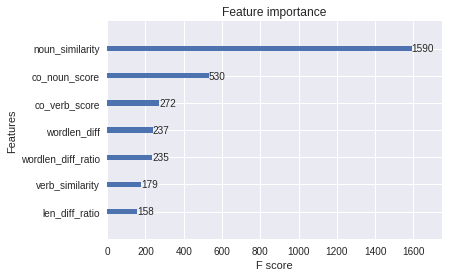

In [40]:
xgb.plot_importance(gbm)

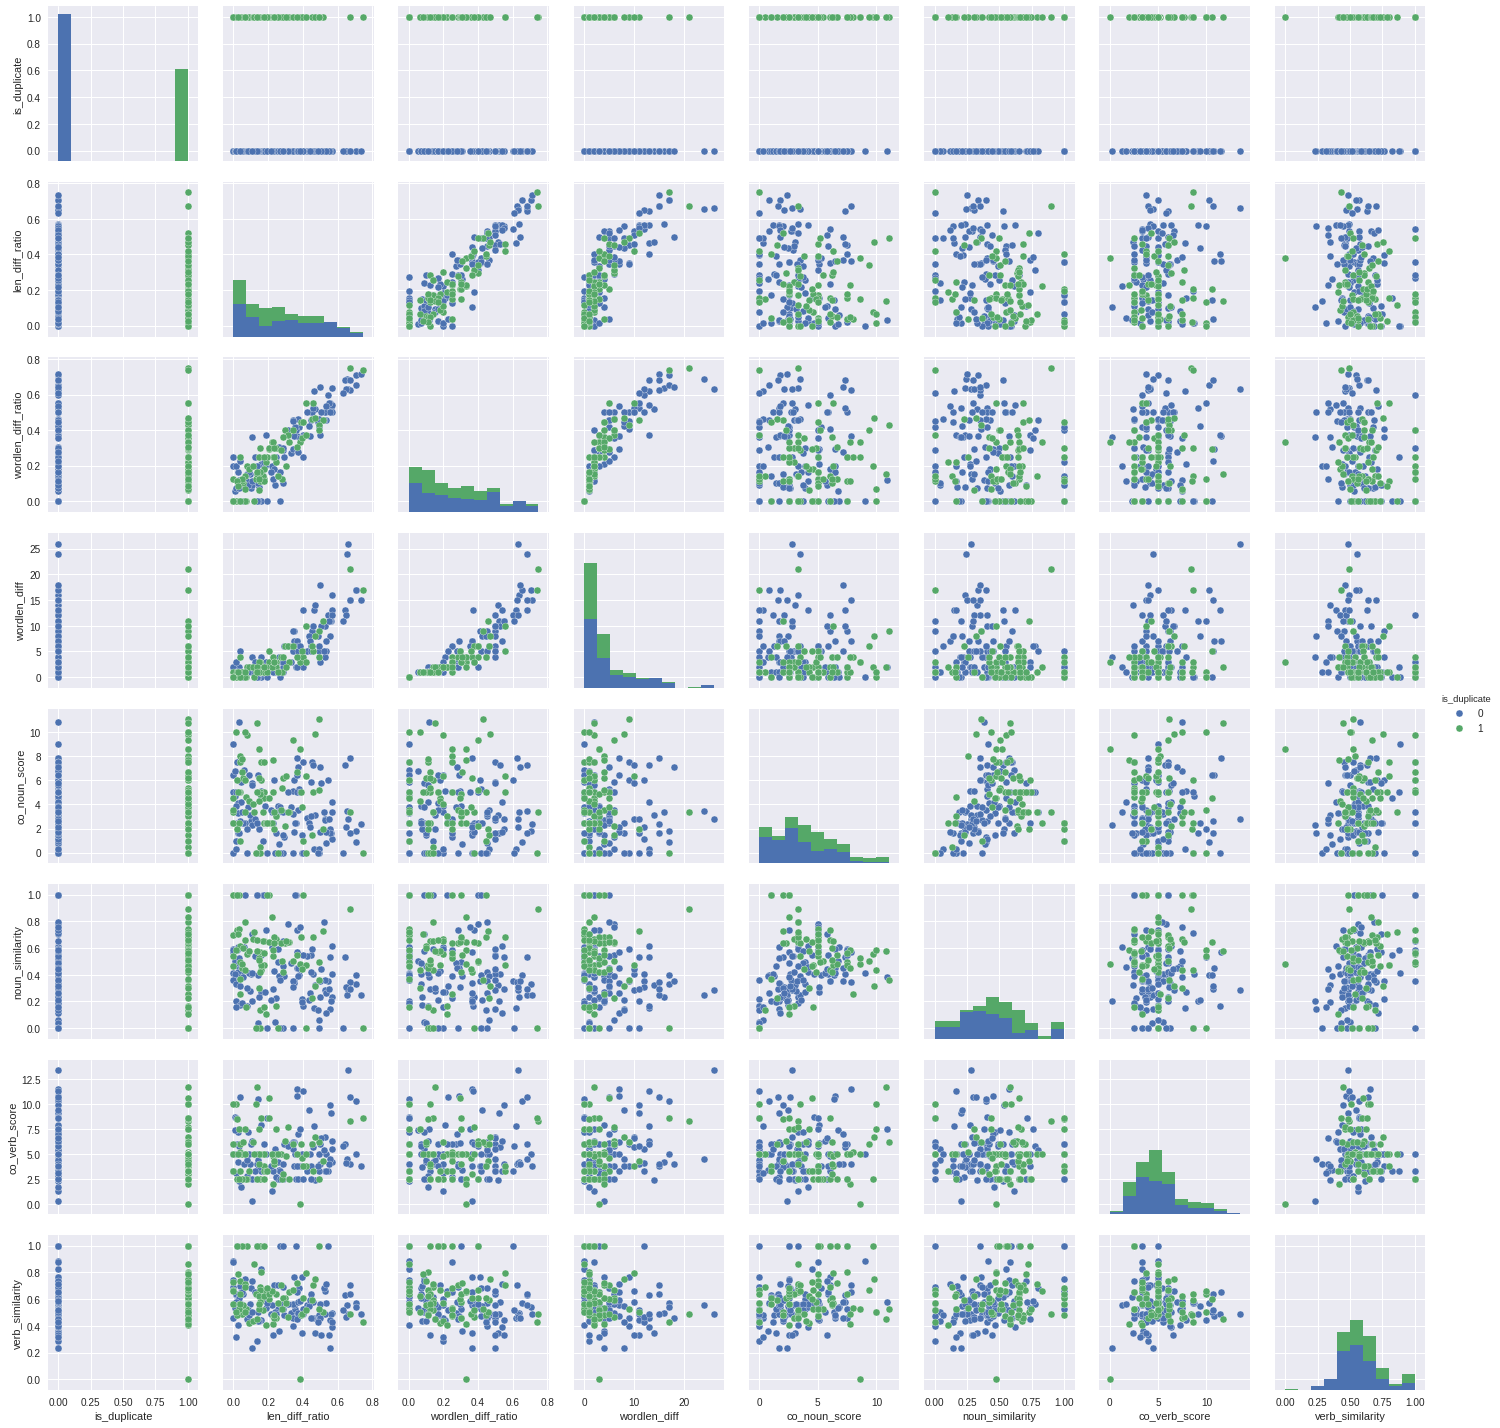

In [41]:
sns.pairplot(df.drop(['id', 'qid1', 'qid2'], axis=1).sample(200), hue='is_duplicate')

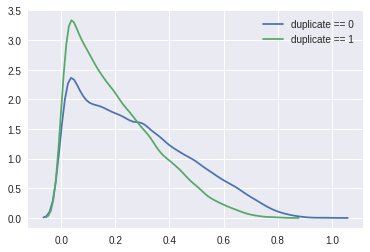

In [44]:
sns.kdeplot(df[df.is_duplicate==0].len_diff_ratio, label="duplicate == 0")
sns.kdeplot(df[df.is_duplicate==1].len_diff_ratio, label="duplicate == 1")

In [50]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [51]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=8))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [52]:
model.fit(X_train.values, pd.get_dummies(y_train).values, epochs=20)

ValueError: Error when checking input: expected dense_1_input to have shape (None, 8) but got array with shape (100000, 7)

In [38]:
log_loss(y_test.values, model.predict(X_test.values)[:,1])

0.76849943242589247

array([  5.89733303e-01,   6.06334031e-01,   1.37432726e-04, ...,
         1.23359617e-02,   6.57993495e-01,   1.83324039e-03], dtype=float32)

In [59]:
ohe.transform(y_train)

/home/sml/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


<1x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements in Compressed Sparse Row format>

In [53]:
X_train

,len_diff_ratio,wordlen_diff_ratio,wordlen_diff,co_noun_score,noun_similarity,co_verb_score,verb_similarity
10000,0.040000,0.000000,0,2.500000,1.000000,5.000000,0.626008
10001,0.074074,0.200000,1,5.000000,0.625421,2.800000,0.414167
10002,0.378947,0.222222,4,0.428571,0.163019,8.000000,0.479734
10003,0.294872,0.090909,1,2.846154,0.329648,3.333333,0.620384
10004,0.000000,0.181818,2,7.500000,0.350602,2.500000,0.522805
10005,0.219178,0.200000,3,4.571429,0.295143,6.666667,0.441360
10006,0.150000,0.250000,2,3.600000,0.281001,3.333333,0.397845
10007,0.222222,0.166667,1,2.500000,1.000000,3.333333,0.638640
10008,0.438356,0.434783,10,1.375000,0.229374,3.636364,0.359580
10009,0.402985,0.416667,5,2.000000,0.536351,4.250000,0.568392
